In [41]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
import pandas as pd

# Load Dataset 
Loading from Hugging Face: I have already prepared and published my dataset on Hugging Face

In [70]:
dataset_dict = load_dataset("zakariajaadi/phishing-url-classification")

In [36]:
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2100
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 450
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 450
    })
})


# Load BERT's model and tokenizer

In [5]:
#BERT Model 
model_checkpoint = "google-bert/bert-base-uncased"

**Load tokenizer and tokenize dataset**

In [6]:
# Load bert tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Apply tokenization to the dataset
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

In [67]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2100
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 450
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 450
    })
})

**Load model with binary classification head** (110M params, 4 Bytes each, model size 440 MB)

In [9]:
id2label = {0: "Safe", 1: "Not Safe"}
label2id = {"Safe": 0, "Not Safe": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           num_labels=2, 
                                                           id2label=id2label, 
                                                           label2id=label2id,)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Freeze base model (BERT) parameters**

In [10]:
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

**Define compute_metrics function to use for training**

In [12]:
# load metrics
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

#Define comp
def compute_metrics(eval_pred):
   
    # Get predictions (logits, actual labels)
    predictions, labels = eval_pred
    
    # apply softmax to get probabilities
    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)
    
    # Sse probabilities of the positive class for ROC AUC
    positive_class_probs = probabilities[:, 1]
    
    # compute auc
    auc =auc_score.compute(prediction_scores=positive_class_probs,references=labels)['roc_auc']
    auc= np.round(auc,3)
    
    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)
   
    # compute accuracy
    acc = accuracy.compute(predictions=predicted_classes,references=labels)['accuracy']
    acc=np.round(acc,3)
    
    return {"Accuracy": acc, "AUC": auc}

In [8]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Train Model

In [28]:
# hyperparameters
lr = 2e-4
batch_size = 8
num_epochs = 10

training_args = TrainingArguments(
    output_dir="bert-phishing-classifier_teacher",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.290600,0.282932,0.871000,0.953000
2,0.319000,0.332050,0.862000,0.956000
3,0.315000,0.297930,0.873000,0.951000
4,0.306100,0.441098,0.833000,0.954000
5,0.318100,0.283394,0.884000,0.955000
6,0.326500,0.265922,0.880000,0.958000
7,0.298600,0.287084,0.876000,0.955000
8,0.288700,0.277855,0.878000,0.956000
9,0.311000,0.270889,0.882000,0.956000
10,0.298400,0.285369,0.876000,0.957000


TrainOutput(global_step=2630, training_loss=0.3072181208505377, metrics={'train_runtime': 2988.2312, 'train_samples_per_second': 7.028, 'train_steps_per_second': 0.88, 'total_flos': 706603239165360.0, 'train_loss': 0.3072181208505377, 'epoch': 10.0})

**Plot Loss train vs validation**

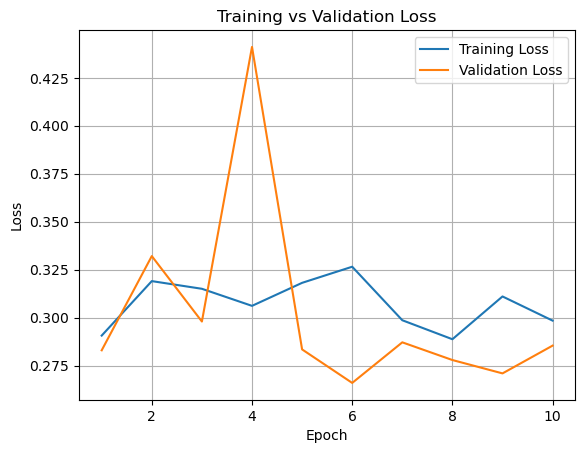

In [33]:
import matplotlib.pyplot as plt

# Extract logs from trainer
logs = trainer.state.log_history

# Initialize lists to store losses and epochs
train_losses = []
val_losses = []
epochs = []

# Iterate through logs and extract training and validation losses
for log in logs:
    if 'loss' in log:  # Training loss
        train_losses.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log:  # Validation loss
        val_losses.append(log['eval_loss'])

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

# 4 - Evaluate model on the test data

In [65]:
# Make predictions for test dataset
predictions = trainer.predict(tokenized_datasets["test"])

# Extract the logits and labels from the predictions
test_y_logits = predictions.predictions
test_y_actual = predictions.label_ids

# Use your compute_metrics function
metrics = compute_metrics((test_y_logits, test_y_actual))
print(metrics)

{'Accuracy': 0.88, 'AUC': 0.958}


> <span style="color:green">**Strong performance 🎉**: </span> **The fine-tuned model shows a good accuracy and a strong descriminative power** 

# Conclusion

>To conclude, the BERT-based phishing URL detection model, fine-tuned on just 2,100 URLs, achieved 88% accuracy and an AUC of 0.958, demonstrating impressive performance for a relatively small dataset. This suggests that BERT is highly effective in identifying phishing URLs, and the model's performance could further improve with more training data.